# Nhận diện cảm xúc khuôn mặt với ResNet-50

## 1. Tiền xử lý dữ liệu

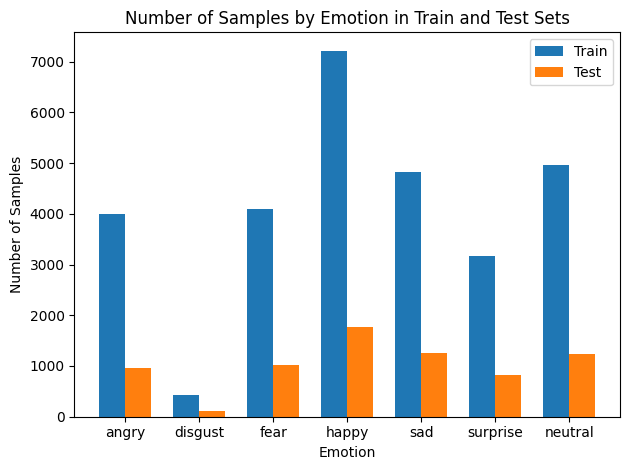

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt

def count_samples(data_dir):
    counts = {}
    label_dict = {
        'angry': 0,
        'disgust': 1,
        'fear': 2,
        'happy': 3,
        'sad': 4,
        'surprise': 5,
        'neutral': 6
    }
    for label in label_dict.keys():
        counts[label] = 0
    for label_name in label_dict.keys():
        folder_path = os.path.join(data_dir, label_name)
        counts[label_name] = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    return counts

# Đếm số lượng mẫu trong tập train và test
train_counts = count_samples('Data/FER_2013/train')
test_counts = count_samples('Data/FER_2013/test')

# Vẽ biểu đồ
labels = list(train_counts.keys())
train_values = list(train_counts.values())
test_values = list(test_counts.values())

x = np.arange(len(labels))  # Vị trí cho các nhãn

fig, ax = plt.subplots()
bar_width = 0.35

# Vẽ các thanh cho tập huấn luyện và tập kiểm tra
bars1 = ax.bar(x - bar_width/2, train_values, bar_width, label='Train')
bars2 = ax.bar(x + bar_width/2, test_values, bar_width, label='Test')

# Thêm một vài thông tin vào biểu đồ
ax.set_xlabel('Emotion')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples by Emotion in Train and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

### Chuyển dữ liệu ảnh 2D sang dạng số

In [43]:
import cv2
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle

def augment_image(image):
    """Tăng cường dữ liệu bằng cách áp dụng các biến đổi đơn giản."""
    augmented_images = []

    # Lật ngang
    flipped = cv2.flip(image, 1)
    augmented_images.append(flipped)

    # Xoay
    for angle in [10, -10]:
        center = (image.shape[1] // 2, image.shape[0] // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
        augmented_images.append(rotated)

    # Thay đổi độ sáng
    for alpha in [0.8, 1.2]:
        bright = cv2.convertScaleAbs(image, alpha=alpha, beta=0)
        augmented_images.append(bright)

    return augmented_images

def load_data_with_augmentation(data_dir):
    images = []
    labels = []
    label_dict = {
        'angry': 0,
        'disgust': 1,
        'fear': 2,
        'happy': 3,
        'sad': 4,
        'surprise': 5,
        'neutral': 6
    }
    
    for label_name, label_value in label_dict.items():
        folder_path = os.path.join(data_dir, label_name)
        
        class_images = []
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh ở định dạng grayscale
            image = cv2.resize(image, (48, 48))  # Đảm bảo kích thước 48x48

            class_images.append(image)

        if label_value == 1:  # Tăng cường dữ liệu cho lớp 'disgust'
            augmented = []
            for img in class_images:
                augmented.extend(augment_image(img))
            class_images = class_images * 6 + augmented
        elif label_value == 5:  # Thêm 20% dữ liệu cho lớp 'surprise'
            extra = int(len(class_images) * 0.2)
            for i in range(extra):
                class_images.append(class_images[i % len(class_images)])
        elif label_value == 3:  # Giảm 30% dữ liệu cho lớp 'happy'
            reduce_count = int(len(class_images) * 0.3)
            class_images = class_images[:-reduce_count]

        for img in class_images:
            images.append(img.flatten())
            labels.append(label_value)

    return np.array(images), np.array(labels)

# Đọc dữ liệu huấn luyện và kiểm tra
X_train, y_train = load_data_with_augmentation('Data/FER_2013/train')
X_test, y_test = load_data_with_augmentation('Data/FER_2013/test')

# Chuyển đổi X thành dạng 4 chiều
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

# Xác định số lượng lớp
num_class = len(set(y_train.tolist()))

# Chuyển đổi nhãn thành dạng one-hot encoding
y_train = np.eye(num_class)[y_train]
y_test = np.eye(num_class)[y_test]

# Kiểm tra lại kích thước của dữ liệu
print(X_train.shape)  # (số lượng mẫu, 48, 48, 1)
print(X_test.shape)   # (số lượng mẫu, 48, 48, 1)
print(y_train.shape)  # (số lượng mẫu, số lượng lớp)
print(y_test.shape)   # (số lượng mẫu, số lượng lớp)


(31539, 48, 48, 1)
(7922, 48, 48, 1)
(31539, 7)
(7922, 7)


In [33]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

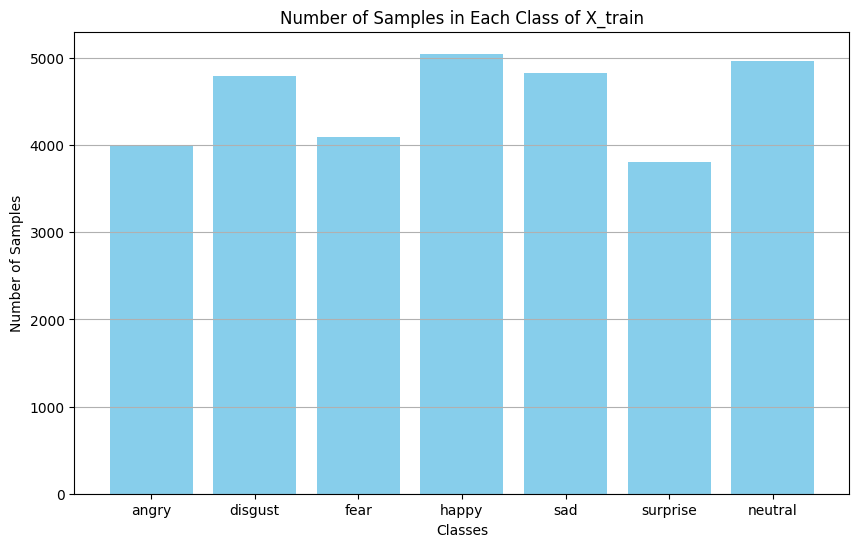

In [44]:
import matplotlib.pyplot as plt

# Đếm số lượng mẫu cho mỗi lớp
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
class_counts = dict(zip(unique, counts))

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(list(class_counts.keys()), ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'])
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class of X_train')
plt.grid(axis='y')
plt.show()

In [35]:
y_train[10]

array([1., 0., 0., 0., 0., 0., 0.])

In [36]:
X_train[0]

array([[[0.19607843],
        [0.1254902 ],
        [0.05882353],
        ...,
        [0.52156866],
        [0.5921569 ],
        [0.3372549 ]],

       [[0.22352941],
        [0.13333334],
        [0.08627451],
        ...,
        [0.5411765 ],
        [0.5921569 ],
        [0.34901962]],

       [[0.23921569],
        [0.11764706],
        [0.09411765],
        ...,
        [0.5568628 ],
        [0.58431375],
        [0.34901962]],

       ...,

       [[0.40392157],
        [0.39215687],
        [0.39215687],
        ...,
        [0.58431375],
        [0.40784314],
        [0.33333334]],

       [[0.41960785],
        [0.43529412],
        [0.44313726],
        ...,
        [0.5921569 ],
        [0.47058824],
        [0.3372549 ]],

       [[0.40784314],
        [0.40784314],
        [0.4392157 ],
        ...,
        [0.56078434],
        [0.53333336],
        [0.3254902 ]]], dtype=float32)

In [66]:
X_train.shape

(28709, 48, 48, 1)

## 2. Triển khai ResNet-50

In [37]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Input, add, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import *
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.metrics import confusion_matrix
import keras.backend as tfback

In [38]:
#
def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


tfback._get_available_gpus = _get_available_gpus
# Lấy danh sách GPU
available_gpus = tfback._get_available_gpus()
# In danh sách GPU
print("Các GPU có sẵn:\n")
for gpu in available_gpus:
    print(gpu)

Các GPU có sẵn:

/device:GPU:0


In [39]:
bn_axis = 1

def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1),
                      kerneal_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [40]:
def ResNet50(include_top=True,
             weights=None,
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    # Num of channels 
    bn_axis = 1

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    img_input = Input(shape=input_shape)

    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    if include_top:
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)
        else:
            warnings.warn('The output shape of `ResNet50(include_top=False)` '
                          'has been changed since Keras 2.2.0.')

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

Epoch 1/32
448/448 [==============================] - 40s 77ms/step - loss: 2.0521 - accuracy: 0.2360 - val_loss: 1.7891 - val_accuracy: 0.2505
Epoch 2/32
448/448 [==============================] - 32s 72ms/step - loss: 1.7783 - accuracy: 0.2626 - val_loss: 1.7736 - val_accuracy: 0.2581
Epoch 3/32
448/448 [==============================] - 42s 93ms/step - loss: 1.7364 - accuracy: 0.2908 - val_loss: 1.6659 - val_accuracy: 0.3541
Epoch 4/32
448/448 [==============================] - 42s 93ms/step - loss: 1.6923 - accuracy: 0.3232 - val_loss: 1.7312 - val_accuracy: 0.2867
Epoch 5/32
448/448 [==============================] - 39s 86ms/step - loss: 1.6468 - accuracy: 0.3458 - val_loss: 1.6109 - val_accuracy: 0.3644
Epoch 6/32
448/448 [==============================] - 42s 93ms/step - loss: 1.6108 - accuracy: 0.3647 - val_loss: 1.6577 - val_accuracy: 0.3610
Epoch 7/32
448/448 [==============================] - 42s 93ms/step - loss: 1.5785 - accuracy: 0.3785 - val_loss: 1.9309 - val_accuracy:

c:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


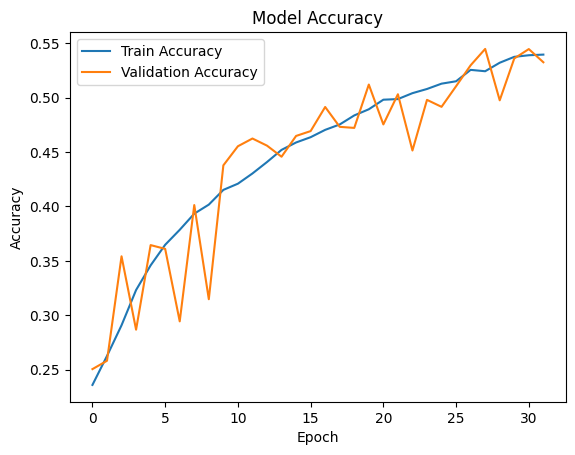

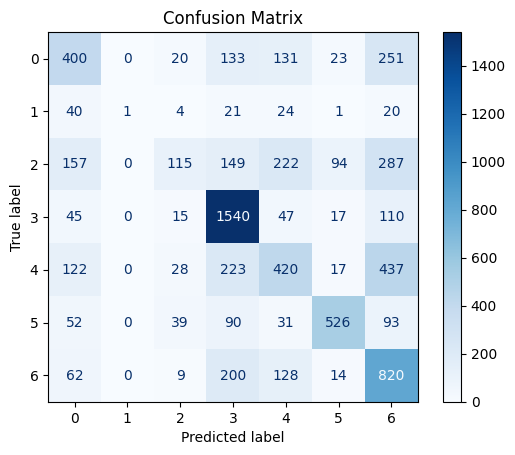

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Thiết lập tham số
batch_size = 64
epochs = 32
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.2, nesterov=False)

# Tạo đối tượng ImageDataGenerator cho dữ liệu tăng cường
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False
)

# Huấn luyện mô hình
# Load ResNet50 model
model = ResNet50(input_shape=(48, 48, 1), classes=7)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd_optimizer)

# Fit dữ liệu tăng cường
datagen.fit(X_train)

# Huấn luyện mô hình và lưu lại lịch sử huấn luyện
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

# Save model
model.save('models/emotion_detection_model.h5')

# Vẽ biểu đồ lịch sử độ chính xác
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Dự đoán nhãn cho tập kiểm tra
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Tính toán ma trận tương quan
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(7))

# Hiển thị ma trận tương quan
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()